In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

In [38]:
J = 5  # the number of harmonics to take in the computation of side bands 
wp = 11.561
Ap0 = 1
L = .6
I_star = 0.6

# An(z=0), the sideband amplitudes at z=0
An0 = 0.00001*np.ones(2*J+1) 
for i in range(2*J+1):
    if (i-J)%2 == 0:
        An0[i] = 0
    else:
        An0[i] = 1/(abs((i-J)))**2

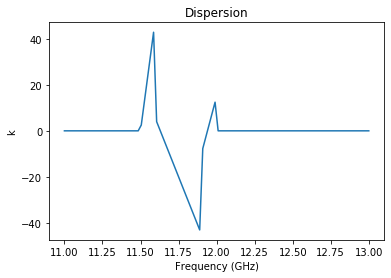

In [39]:
# dispersion relation k~w, should be some 4th order polynomial approx, but now just hard code a dispersion
def dispersion(w): 
    if w <= 11.5:
        k = 0
    if 11.5 < w < 11.6:
        k = (50/0.1)*(w-11.5)
    if 11.6 < w < 11.9:
        k = (-50/0.3)*(w-11.6) + 5
    if 11.9 < w < 12:
        k = (25/0.1)*(w-11.9) - 10
    if w >= 12:
        k = 0 
    return k

t = np.linspace(11, 13, 100)  
y = np.zeros(len(t))         
for i in range(len(t)):
    y[i] = dispersion(t[i])

plt.plot(t, y)
plt.xlabel('Frequency (GHz)')
plt.ylabel('k')
plt.title('Dispersion' )
plt.show()

In [40]:
def signal_gains(ws, wp=wp, Ap0=Ap0, An0=An0, I_star=I_star, L=L, J=J):
    
    # create wn from n
    def wn_cal(n, wp=wp, ws=ws):
        return n*wp + ws - wp

    def del_kn_cal(n, wp=wp, ws=ws):
        kn = dispersion(wn_cal(n, wp=wp, ws=ws))
        kn_minus_2 = dispersion(wn_cal(n-2, wp=wp, ws=ws))
        kp = dispersion(wp)
        return kn - kn_minus_2 - 2*kp

    # create a dictionary of vn's 
    def vn_gen(n, J=J):
        vn = np.empty(J+1)
        for num in range(J+1):
            j = num+1 # the j in Eq. 9a
            if 1 <= j <= 1 + (n+J)/2:
                vn[num]= 1
            if 1 + (n+J)/2 < j <= J+1:
                vn[num]=-1
        return vn
   
    # calculate delta phi
    del_phi = dispersion(wp)*Ap0**2/(8*I_star**2)

    # calculate K
    K = np.empty(J+1)
    K[0] = 0
    for num in range(1, J+1):
        K[num] = del_kn_cal(-J + 2*num) + 2*del_phi
        
    # construct Coefficient matrix for the linear ODEs for Bn
    # this is a (2J+1)*(2J+1) matrix, corresponding to -J,...,0,...,+J
    CoefficientMatrix = np.zeros([2*J+1,2*J+1], dtype=np.complex_)
    for num in range(2*J+1):
        n = num - J
        if n%2 == 0:
            continue
        if n-2 >= -J: 
            CoefficientMatrix[num, num-2] = -wn_cal(n)*del_phi/wp * 1.j
        CoefficientMatrix[num, num] = -np.dot(vn_gen(n), K) * 1.j
        if n+2 <= J:
            CoefficientMatrix[num, num+2] = -wn_cal(n)*del_phi/wp * 1.j
    
    # solve the eigenvalue problem of the coefficient matrix
    eigenval, eigenmatrix = np.linalg.eig(CoefficientMatrix)
    
    # multiply e^(lanbda*z) with C
    C = np.linalg.solve(eigenmatrix, An0) # C: coefficients
    prop = np.multiply(np.exp(eigenval*L), C)
    
    # find Bz and back derive Az
    Bz = np.matmul(eigenmatrix, prop)
    Bz1 = Bz[J+1]
    Az1 = Bz1 * np.exp(1.j * ( (2*wn_cal(n)*del_phi/wp)- 0.5*(np.dot(vn_gen(1), K)) ))
    
    Gs = np.absolute(Az1/An0[J+1])
    Gs = 10*np.log10(Gs) # convert gain to dB
    
    return Gs

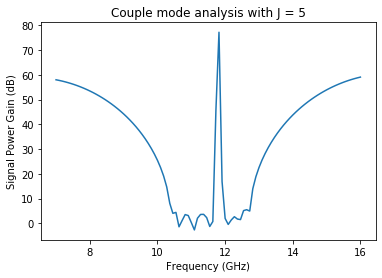

In [41]:
# reproduce the graph (Fig.3 in Chaudhuri et al)
I_s = 0.242
t = np.linspace(7, 16, 100)  
y = np.zeros(len(t))         
for i in range(len(t)):
    y[i] = signal_gains(t[i], I_star=I_s)

plt.plot(t, y)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Signal Power Gain (dB)')
plt.title(f'Couple mode analysis with J = {J}' )
plt.show()